In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service

service = get_tap_service("tap")

# Counter-part simulation


## Redshift and absolute magnitude

We try to simulate a distribution of sourcecs similiar to the one of Kann et al., 2011.

<img src="https://s3.amazonaws.com/aasie/images/0004-637X/734/2/96/apj387210f16_hr.jpg"/>

The method is very rough and will show its limitation for large samples. However, for a small sample, it should be fine-ish. We may improve it later.

In [2]:
def generate_samples(n: int, seed: int | None = None):
    if seed is not None:
        np.random.seed(seed)
    dist_binom = stats.bernoulli(p=0.2)
    dist_zt1 = stats.uniform(scale = 1, loc=0.08)
    dist_mt1 = stats.uniform(scale = 9, loc=-21)
    dist_zt2 = stats.uniform(scale = 8, loc=0.3)
    dist_mt2 = stats.uniform(scale = 7, loc=-26)

    samples_binom = dist_binom.rvs(n)
    nt1 = len(samples_binom[samples_binom == 1])
    nt2 = n - nt1
    samples_zt1 = dist_zt1.rvs(nt1)
    samples_mt1 = dist_mt1.rvs(nt1)
    samples_zt2 = dist_zt2.rvs(nt2)
    samples_mt2 = dist_mt2.rvs(nt2)
    out =  np.hstack((
        np.vstack((samples_zt1, samples_mt1, np.ones(nt1))),
        np.vstack((samples_zt2, samples_mt2, np.zeros(nt2))),
    )).T
    return out

In [3]:
ss = generate_samples(80, seed=0)

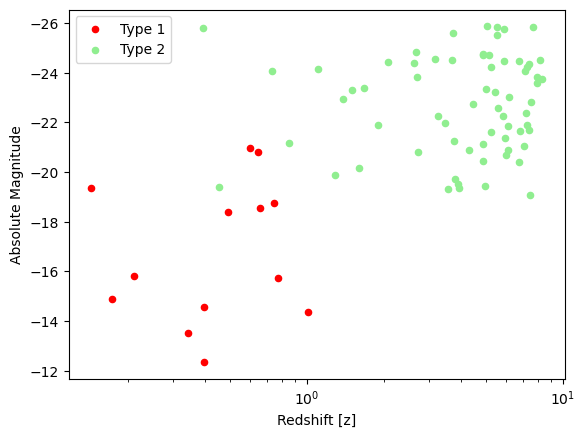

In [4]:
mask = ss[:,2] == 1
plt.scatter(ss[mask][:, 0], ss[mask][:, 1], c="red", s = 20, label="Type 1")
plt.scatter(ss[~mask][:, 0], ss[~mask][:, 1], c="lightgreen", s = 20, label="Type 2")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.ylabel("Absolute Magnitude")
plt.xlabel("Redshift [z]")
plt.legend()
plt.show()

## Apparent magnitude

We have to transform magnitudes, absolute to apparent. To achieve this we compute the luminosity distance according:
$$ D_L = 10^{\frac{(m - M)}{5}+1} $$
The cosmology we take into account is a Flat Lambda CDM with $H_0=70$ and $\Omega_m = 0.3$.

In [5]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

def zm2appmag(z, abs_mag):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    luminosity_distance = cosmo.luminosity_distance(z).to(u.pc).value
    return float(abs_mag + 5 * np.log10(luminosity_distance) - 5)

appmag = np.array([*map(lambda x: zm2appmag(x[0], x[1]), ss)])

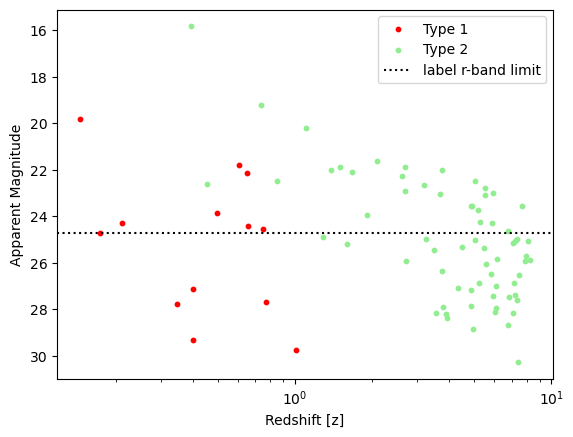

In [6]:
mask = ss[:,2] == 1
plt.scatter(ss[mask][:, 0], appmag[mask], c="red", s = 10, label="Type 1")
plt.scatter(ss[~mask][:, 0], appmag[~mask], c="lightgreen", s = 10, label="Type 2")
plt.axhline(24.7, label="label r-band limit", linestyle=":", color="k")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.ylabel("Apparent Magnitude")
plt.xlabel("Redshift [z]")
plt.legend()
plt.show()

Finally we put everything together into a dataframe for the synthetic sources.

In [159]:
def generate_source_table(n: int, seed: int | None = None):
    if seed is not None:
        np.random.seed(seed)
    ss = generate_samples(n)
    appmag = np.array([*map(lambda x: zm2appmag(x[0], x[1]), ss)])
    return pd.DataFrame({
        "redshift": ss[:, 0],
        "m": appmag,
        "M": ss[:, 1],
        "pop": [*map(lambda x: -x + 2, ss[:, 2])]
    })

sources_df = generate_source_table(80, 0)

In [160]:
sources_df.describe()

,redshift,m,M,pop
count,80.000000,80.000000,80.000000,80.000000
mean,4.036992,25.013480,-21.771036,1.837500
std,2.548150,2.656839,3.060523,0.371236
min,0.144147,15.823521,-25.870347,1.000000
25%,1.467638,23.021737,-24.220231,2.000000
50%,4.389444,25.053976,-22.101673,2.000000
75%,6.029559,27.125390,-20.355919,2.000000
max,8.290776,30.278360,-12.340303,2.000000


We cut sources under magnitude 24.7, the LSST r-band, single exposure magnitude limit and describe the reduced dataframe content.

In [161]:
sources_df[sources_df["m"] < 24.7].describe()

,redshift,m,M,pop
count,34.000000,34.000000,34.000000,34.000000
mean,2.840202,22.537848,-23.152877,1.794118
std,2.241772,1.759294,2.656425,0.410426
min,0.144147,15.823521,-25.870347,1.000000
25%,0.737881,22.002291,-24.732218,2.000000
50%,2.352637,22.700756,-24.313801,2.000000
75%,5.000902,23.684568,-21.363814,2.000000
max,7.655861,24.621743,-15.814584,2.000000


## Hosts and coordinates

Finally we asssociate, whenever possible, a random simulated source to each transient. For transients at high z, a suitable host may not be present in the DC0.2 truth catalog. When this happen, we do not assign a counterparts to the source, simulating a scenario in which the host is too far to be resolved.

In [165]:
sources_df = sources_df[sources_df["m"] < 24.7].reset_index(drop=True)
sources_df[:10]

,redshift,m,M,pop
0,0.494263,23.835787,-18.395345,1.0
1,0.144147,19.820295,-19.351278,1.0
2,0.646601,22.117489,-20.819032,1.0
3,0.603248,21.795481,-20.957741,1.0
4,0.655946,24.404574,-18.569928,1.0
5,0.747410,24.559995,-18.761222,1.0
6,0.211798,24.280997,-15.814584,1.0
7,5.036335,22.492464,-25.870347,2.0
8,2.084653,21.634779,-24.432527,2.0
9,5.895834,22.985564,-25.777127,2.0


In [169]:
ramin, ramax = 55, 70
decmin, decmax = -42.5, -30.0


def verbose(f):
    COUNTER = [0]

    def helper(*args, **kwargs):
        print(f"on iteration {COUNTER[0]}..")
        r =  f(*args, **kwargs)
        print(f"  found a host with ra={r['ts_ra']:.2f}, dec={r['ts_dec']:.2f}, z={r['ts_redshift']:.2f}.")
        COUNTER[0] += 1
        return r
    return helper
    
    
def find_random_host(redshift, tol=0.1, ramin=55, ramax=70, decmin=-42, decmax=-30, max_attempts=5):
    random_ra = float(stats.uniform(scale=ramax-ramin, loc=ramin).rvs(1)[0])
    random_dec = float(stats.uniform(scale=decmax-decmin, loc=decmin).rvs(1)[0])

    attempts = 0
    candidates = pd.DataFrame({})
    while len(candidates) == 0:
        # query sources in a random small cone region of the simulation domain
        query = (
            "SELECT ts.ra AS ts_ra, "
            "ts.dec AS ts_dec, "
            "ts.mag_r AS ts_mag_r, "
            "ts.id_truth_type AS ts_idtruth, "
            "ts.redshift AS ts_redshift, "
            "ts.flux_r AS ts_flux_r "
            "FROM dp02_dc2_catalogs.TruthSummary AS ts "
            f"WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', {random_ra:.2f}, {random_dec:.2f}, 0.1)) = 1 "
            # we seek sources with redshift "close" to the simulated value
            f"AND ts.redshift >= {redshift - redshift * tol} "
            f"AND ts.redshift < {redshift + redshift * tol} "
            "AND ts.truth_type = 1 " # galaxies
        )
        
        job = service.submit_job(query)
        job.run()
        job.wait(phases=['COMPLETED', 'ERROR'])
        candidates = job.fetch_result().to_table().to_pandas()
        if attempts > max_attempts:
            # if we exceed max attempts we retun no information on the host
            print(f"  ! Could not find a suitable host at z={redshift:.2f}. Returning made up values.")
            return {
                'ts_ra': random_ra,
                'ts_dec': random_dec,
                'ts_mag_r': None,
                'ts_idtruth': None,
                'ts_redshift': redshift,
                'ts_flux_r': None,
            }
        # if we don't find a counterpart we try again up a max numberr off times 
        attempts += 1
    return candidates.sample(1).to_dict("records")[0]


hosts = [*map(verbose(find_random_host), sources_df["redshift"])]

on iteration 0..
  found a host with ra=56.30, dec=-32.61, z=0.45.
on iteration 1..
  found a host with ra=58.41, dec=-36.57, z=0.14.
on iteration 2..
  found a host with ra=65.13, dec=-34.58, z=0.66.
on iteration 3..
  found a host with ra=60.70, dec=-32.29, z=0.58.
on iteration 4..
  found a host with ra=64.99, dec=-38.78, z=0.72.
on iteration 5..
  found a host with ra=65.16, dec=-41.35, z=0.68.
on iteration 6..
  found a host with ra=61.28, dec=-35.05, z=0.23.
on iteration 7..
  ! Could not find a suitable host at z=5.04. Returning made up values.
  found a host with ra=57.09, dec=-34.24, z=5.04.
on iteration 8..
  found a host with ra=57.07, dec=-30.22, z=2.07.
on iteration 9..
  ! Could not find a suitable host at z=5.90. Returning made up values.
  found a host with ra=60.46, dec=-39.01, z=5.90.
on iteration 10..
  found a host with ra=68.69, dec=-31.61, z=2.87.
on iteration 11..
  ! Could not find a suitable host at z=3.69. Returning made up values.
  found a host with ra=65.39

Let's concatenate the dataframe together.. We have the simulation inputs!

In [174]:
pd.concat((sources_df, pd.DataFrame(hosts)), axis= 1)

,redshift,m,M,pop,ts_ra,ts_dec,ts_mag_r,ts_idtruth,ts_redshift,ts_flux_r
0,0.494263,23.835787,-18.395345,1.0,56.295541,-32.613133,26.900499,4125325453_1,0.453440,63.069500
1,0.144147,19.820295,-19.351278,1.0,58.409328,-36.574075,24.462299,7875014044_1,0.137955,595.778015
2,0.646601,22.117489,-20.819032,1.0,65.128145,-34.581217,27.648300,6063428639_1,0.658063,31.671000
3,0.603248,21.795481,-20.957741,1.0,60.699601,-32.288511,28.587900,5063078498_1,0.575817,13.329800
4,0.655946,24.404574,-18.569928,1.0,64.985955,-38.778764,27.782499,8938589889_1,0.718282,27.990400
5,0.747410,24.559995,-18.761222,1.0,65.164531,-41.348208,26.333099,10563456582_1,0.681200,106.356003
6,0.211798,24.280997,-15.814584,1.0,61.276533,-35.052897,22.501499,6000041194_1,0.231770,3625.600098
7,5.036335,22.492464,-25.870347,2.0,57.092795,-34.239351,NaN,None,5.036335,NaN
8,2.084653,21.634779,-24.432527,2.0,57.069882,-30.221394,27.260599,3388098280_1,2.066950,45.265099
9,5.895834,22.985564,-25.777127,2.0,60.462576,-39.008542,NaN,None,5.895834,NaN
